<h1> Baseline Model Notebook

<h4> Since we were using datasets from Google's cloudbase, this notebook was run in Google Colab.

In [ ]:
!gsutil -m cp "gs://quickdraw_dataset/full/numpy_bitmap/*.npy" /content/Data/


Copying gs://quickdraw_dataset/full/numpy_bitmap/The Eiffel Tower.npy...
Copying gs://quickdraw_dataset/full/numpy_bitmap/The Great Wall of China.npy...
Copying gs://quickdraw_dataset/full/numpy_bitmap/aircraft carrier.npy...
Copying gs://quickdraw_dataset/full/numpy_bitmap/The Mona Lisa.npy...
Copying gs://quickdraw_dataset/full/numpy_bitmap/airplane.npy...
Copying gs://quickdraw_dataset/full/numpy_bitmap/alarm clock.npy...
Copying gs://quickdraw_dataset/full/numpy_bitmap/ambulance.npy...
Copying gs://quickdraw_dataset/full/numpy_bitmap/angel.npy...
Copying gs://quickdraw_dataset/full/numpy_bitmap/animal migration.npy...
Copying gs://quickdraw_dataset/full/numpy_bitmap/ant.npy...
Copying gs://quickdraw_dataset/full/numpy_bitmap/anvil.npy...
Copying gs://quickdraw_dataset/full/numpy_bitmap/apple.npy...
Copying gs://quickdraw_dataset/full/numpy_bitmap/arm.npy...
Copying gs://quickdraw_dataset/full/numpy_bitmap/asparagus.npy...
Copying gs://quickdraw_dataset/full/numpy_bitmap/axe.npy...


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import subprocess
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
import os

directory = '/content/Data/'

class_names = set()
for filename in os.listdir(directory):
    if filename.endswith('.npy'):
        class_name = os.path.splitext(filename)[0]
        class_names.add(class_name)

print(class_names)

{'passport', 'microphone', 'paint can', 'The Great Wall of China', 'television', 'headphones', 'hexagon', 'broom', 'yoga', 'castle', 'bicycle', 'stitches', 'zebra', 'strawberry', 'garden hose', 'camel', 'pineapple', 'washing machine', 'peanut', 'motorbike', 'skyscraper', 'basketball', 'calendar', 'cell phone', 'stove', 'cake', 'ambulance', 'airplane', 't-shirt', 'tree', 'flamingo', 'leaf', 'envelope', 'barn', 'spider', 'shorts', 'ant', 'duck', 'cow', 'nail', 'bandage', 'stop sign', 'star', 'matches', 'postcard', 'key', 'flashlight', 'bat', 'knife', 'banana', 'school bus', 'picture frame', 'shovel', 'moon', 'paintbrush', 'cruise ship', 'rabbit', 'candle', 'house', 'helicopter', 'angel', 'mouth', 'chair', 'square', 'windmill', 'river', 'mug', 'pliers', 'hot tub', 'lighter', 'skateboard', 'crayon', 'shoe', 'helmet', 'crocodile', 'camera', 'house plant', 'hot air balloon', 'kangaroo', 'horse', 'necklace', 'tractor', 'alarm clock', 'bee', 'harp', 'clarinet', 'suitcase', 'mermaid', 'crown', 

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split

# Set up paths to data files
data_dir = '/content/Data'
data_files = os.listdir(data_dir)[:80]

# Set up empty lists for data and labels
data_list = []
label_list = []

# Loop through each data file and append data and label to the respective lists
for i, file in enumerate(data_files):
  data = np.load(os.path.join(data_dir, file))[:1000] # load first 100 data points from each file
  label = np.ones((data.shape[0],), dtype=np.int64) * i # set label to file index for this data
  data_list.append(data)
  label_list.append(label)

# Concatenate data and labels into single arrays
data = np.concatenate(data_list, axis=0)
labels = np.concatenate(label_list, axis=0)

# Convert data and labels to PyTorch tensors
data = torch.from_numpy(data)
labels = torch.from_numpy(labels)

# Create dataset from data and labels
dataset = TensorDataset(data, labels)

# Split dataset into train, val, and test sets
num_samples = len(dataset)
num_train_samples = int(num_samples * 0.7)
num_val_samples = int(num_samples * 0.15)
num_test_samples = num_samples - num_train_samples - num_val_samples

train_dataset, val_dataset, test_dataset = random_split(dataset, [num_train_samples, num_val_samples, num_test_samples])

# Create dataloaders for each set
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)


In [ ]:
class BaselineANN(nn.Module):
    def __init__(self):
        super(BaselineANN, self).__init__()
        self.name = 'ANN'
        self.layer1 = nn.Linear(28 * 28, 500)
        self.layer2 = nn.Linear(500,200)
        self.layer3 = nn.Linear(200, 100)
    def forward(self, img):
        activation1 = self.layer1(img)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        activation2 = F.relu(activation2)
        activation3 = self.layer3(activation2)
        activation3 = activation3.squeeze(1)
        return activation3

In [ ]:
def model_accuracy(model, loader):
    correct = 0 #correctly predicted labels
    total = 0 #total number of labels
    with torch.no_grad(): #only evaluating - interested only in output
        for images, labels in loader:
            outputs = model(images.float())
            something, predicted = torch.max(outputs.data, 1) #get predicted class label for each image
            total += labels.size(0) #update total number of labels
            correct += (predicted == labels).sum().item() 
            #only update correct number of labels if predicted matches ground truth
    #print('Accuracy on {} dataset: {} %'.format(dataset, (100 * correct / total)))#show accuracy
    return 100 * correct / total

In [ ]:
def train(model, train_loader, val_loader, test_loader, batch_size, learning_rate, num_epochs):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    epochs = np.arange(1,num_epochs+1)
    train_acc = []
    val_acc = []
    train_losses = []
    val_losses = []

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)


    for epoch in range(num_epochs):
        train_loss = 0.0
        val_loss = 0.0
        model.train()
        for i, (images, labels) in enumerate(train_loader):

            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            outputs = model(images.float())
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)

        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:

                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images.float())
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)

        train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        train_accuracy = model_accuracy(model, train_loader)
        train_acc.append(train_accuracy)
        val_accuracy = model_accuracy(model, val_loader)
        val_acc.append(val_accuracy)
        
        print('Epoch [{}/{}], Training Loss: {:.4f}, Validation Loss: {:.4f}, Training Accuracy: {:.4f}, Validation Accuracy: {:.4f}'
              .format(epoch+1, num_epochs, train_loss, val_loss, train_accuracy, val_accuracy))
    if (epoch+1)%10 == 0:
      torch.save(model.state_dict(), 'baseline_model.pth')

    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:

            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images.float())
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Compute the average test loss and accuracy
    test_loss = test_loss / len(test_loader.dataset)
    test_accuracy = model_accuracy(model, test_loader)


    print('Test Loss: {:.4f}, Test Accuracy: {:.2f}%'.format(test_loss, test_accuracy))
    return train_losses, val_losses, train_acc, val_acc,epochs

model1 = BaselineANN()

train_losses, val_losses, train_acc, val_acc,epochs = train(model1, \
      train_loader=train_loader, val_loader=val_loader, test_loader=test_loader,\
      batch_size=32, learning_rate=0.001, num_epochs=50)


Epoch [1/50], Training Loss: 4.3984, Validation Loss: 3.9459, Training Accuracy: 8.3357, Validation Accuracy: 8.3400
Epoch [2/50], Training Loss: 3.5396, Validation Loss: 3.2859, Training Accuracy: 20.2243, Validation Accuracy: 19.4667
Epoch [3/50], Training Loss: 3.1285, Validation Loss: 3.0834, Training Accuracy: 25.9100, Validation Accuracy: 24.4600
Epoch [4/50], Training Loss: 2.9480, Validation Loss: 3.0105, Training Accuracy: 28.9943, Validation Accuracy: 26.9267
Epoch [5/50], Training Loss: 2.8500, Validation Loss: 3.0162, Training Accuracy: 30.3757, Validation Accuracy: 27.6533
Epoch [6/50], Training Loss: 2.7746, Validation Loss: 2.9951, Training Accuracy: 32.2286, Validation Accuracy: 29.1667
Epoch [7/50], Training Loss: 2.7083, Validation Loss: 2.9773, Training Accuracy: 32.5700, Validation Accuracy: 28.8533
Epoch [8/50], Training Loss: 2.6671, Validation Loss: 2.9755, Training Accuracy: 34.6129, Validation Accuracy: 29.5933
Epoch [9/50], Training Loss: 2.6246, Validation Lo

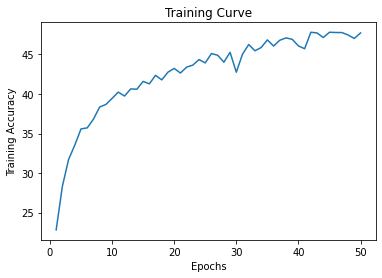

Text(0, 0.5, 'Validation Accuracy')

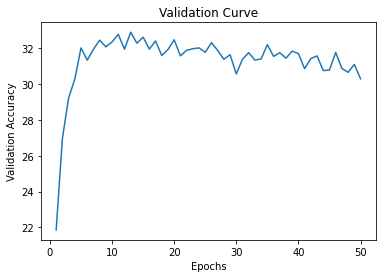

In [ ]:
plt.plot(epochs, train_acc)
plt.title("Training Curve")
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.show()

plt.plot(epochs, val_acc)
plt.title("Validation Curve")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")

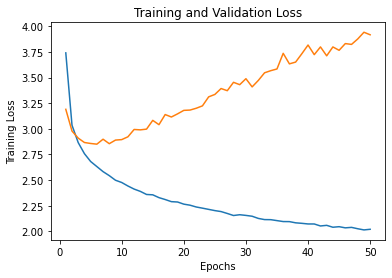

In [ ]:
plt.plot(epochs, train_losses)
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.plot(epochs, val_losses)
plt.show()

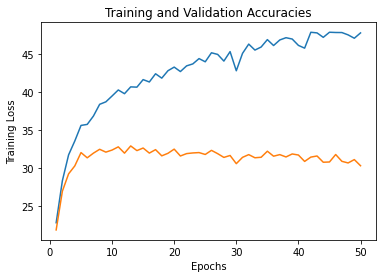

In [ ]:
plt.plot(epochs, train_acc)
plt.title("Training and Validation Accuracies")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(epochs, val_acc)
plt.show()